In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pytestlab.instruments import AutoInstrument
import time

In [2]:

# Define frequency sweep parameters
start_frequency = 10  # Hz
stop_frequency = 1e7  # Hz
start_log = int(np.log10(start_frequency))
stop_log = int(np.log10(stop_frequency))
points_per_decade = 10
frequencies = np.logspace(start_log,stop_log,(stop_log-start_log)*points_per_decade).astype(float)
offset = 1.5
amplitude = 0.4
channel = 1

# Instantiate the instruments
try:
    osc = AutoInstrument.from_config("keysight/DSOX1204G")
    awg = AutoInstrument.from_config("keysight/EDU33212A")
except Exception as e:
    print(f"Error initializing instruments: {e}")
    exit()

# Initialize lists to store data
measured_frequencies = []
amplitudes_db = []

try:
    # Configure AWG (initial settings)
    awg.set_waveform(channel, "SIN")  # Set to sine wave
    awg.set_amplitude(channel, amplitude)  # 1V amplitude
    awg.set_offset(channel, offset)  # 0V offset
    osc.set_channel_axis(channel, 1, 2.5)

    osc.display_channel(1, True)  # Make sure channel 1 is displayed
    # Sweep through frequencies


    for i,frequency in enumerate(frequencies):
        time_per_division = (1 / frequency)  # Display at least two periods
        osc.set_time_axis(time_per_division, 0)
        awg.output(channel, True)
        awg.set_frequency(channel, frequency)
        time.sleep(0.1)  # Allow time to stabilize

        # Measure peak-to-peak voltage
        measurement = osc.measure_voltage_peak_to_peak(1)

        # Convert to dB
        amplitude_db = 20 * np.log10(float(measurement.values))

        measured_frequencies.append(frequency)
        amplitudes_db.append(amplitude_db)



except Exception as e:
    print(f"Error during frequency sweep: {e}")

finally:
    # Clean up
    if 'awg' in locals():
        awg.output(channel, False)
        awg.close()
    if 'osc' in locals():
        osc.close()

SIN


In [3]:
# Save the arrays to a single file
file_path = "data.npz"  # Use the .npz extension
np.savez(file_path, arr1=measured_frequencies, arr2=amplitudes_db)

print(f"Arrays saved to {file_path}")

Arrays saved to data.npz


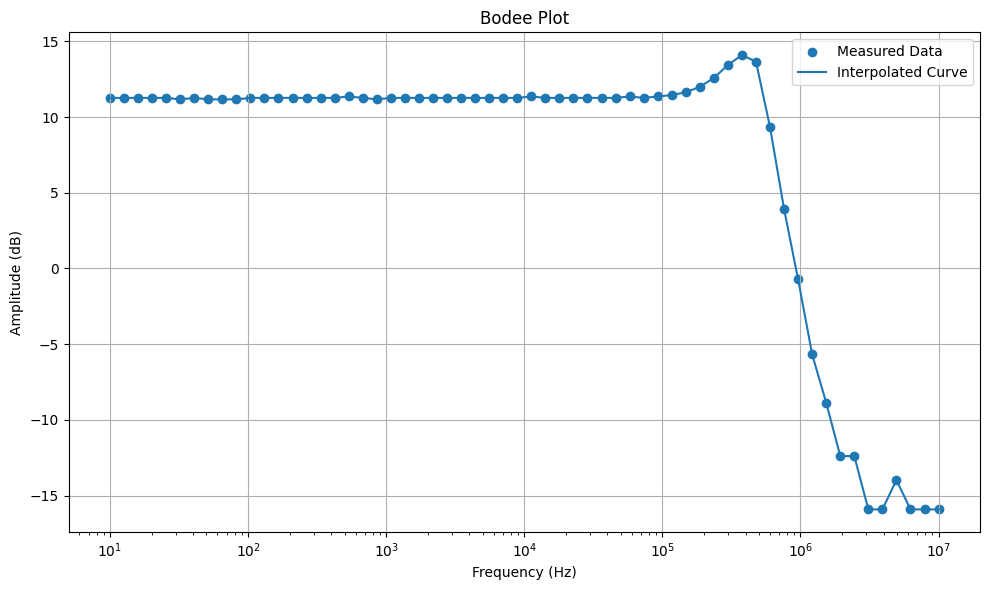

In [4]:
# Plotting the Bode plot
plt.figure(figsize=(10, 6))
plt.scatter(measured_frequencies, amplitudes_db, label='Measured Data')  # Added label for clarity
plt.plot(measured_frequencies, amplitudes_db, linestyle='-', label='Interpolated Curve')  # Added linestyle for a continuous line

plt.title("Bodee Plot")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")  # Ensure x-axis is logarithmic
plt.grid(True)
plt.legend()  # Show the legend to identify the data
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()